## Построение более сложных классификаторов

Зададимся вопросом: "Как вообще можно охарактеризовать модель классификации?". Можно выделить три части.
* __Структура модели.__ Как именно модель принимает решения? Например, решение может зависеть от того, будет значение конкретного признака больше или меньше порогового. Это годится только для самых простых задач.
* __Процедура поиска.__ Как мы находим подходящую модель? Например, опробовать все комбинации признака и порогового значения. Нетрудно сообразить, что с увеличением сложности модели и размера набора данных полный перебор всех комбинаций становится невозможным и приходится  использовать приближенные решения. Поэтому для поиска хорошего решения часто используются изощренные методы оптимизации.
* __Функция выигрыша или функция потерь.__ Как мы решаем, какую из рассмотренных моделей возвращать? Редко удается найти идеальную модель, которая вообще не делает ошибок, поэтому нужно решить, какую использовать. Мы брали в качестве критерия accuracy, но иногда полезнее выбирать модель, которая делает наименьшее количество ошибок определенного вида. Эти проблемы можно обсуждать в терминах выигрыша (который мы хотим максимизировать) или потерь (которые мы хотим вести к минимуму). Оба взгляда эквивалентны, но иногда удобнее один, а иногда другой.

## Набор данных Seeds

In [1]:
import numpy as np


def load_dataset(dataset_name):
    '''
    Загружает набор с именем dataset_name

    Returns
    -------
    data : numpy ndarray
    labels : список строк
    '''
    data = []
    labels = []
    with open('./data/{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            data.append([float(tk) for tk in tokens[:-1]])
            labels.append(tokens[-1])
    
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [2]:
features, labels = load_dataset('seeds')

Возьмем еще один набор данных из области ботаники, тоже небольшой, но уже не такой маленький, чтобы его можно было целиком изобразить на печатной странице, как в случае набора Iris. В этот набор входят данные об измерениях семян пшеницы. Всего есть семь признаков:
* площадь (area): $А$;
* периметр (perimeter): $Р$;
* компактность (compactness): $С = \dfrac{4\pi A}{P^2}$;
* длина зерна (length of kernel);
* ширина зерна (width of kernel);
* коэффициент асимметрии (asymmetry coefficient);
* длина желобка зерна (length of kernel groove).

In [3]:
feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]

Существует три класса, соответствующие трем, сортам пшеницы: __Canadian__, __Коma__ и __Rosa__. Как и раньше, наша цель - научиться классифицировать образцы по этим морфологическим измерениям. В отличие от набора данных Iris, который был создан в 1930-х годах, это совсем недавний набор, для которого признаки автоматически вычислялись путем обработки цифровых изображений.

Вот как можно __реализовать автоматическое распознавание образов__: берем изображения,  представленные в цифровом виде, вычисляем по ним интересующие нас признаки и применяем общую систему классификации.

## Признаки и подготовка признаков (feature engineering)

У этих признаков есть интересная особенность: компактность - не результат независимого измерения, а функция двух предыдущих признаков, площади и периметра. Такое выведение новых признаков из существующих часто бывает очень полезно. Деятельность по созданию новых признаков называют __подготовкой признаков (feature engineering)__. Она не такая эффектная, как применение алгоритмов, но нередко оказывает на качество работы даже большее влияние (простой алгоритм на хорошо подобранных признаках работает лучше, чем изощренный алгоритм на плохих признаках).

__Компактность (compactness)__ - типичный признак геометрических фигур. Иногда его еще называют __округленностью, закругленность (roundness)__. Этот признак будет одинаков для двух зерен одинаковой формы, из которых одно вдвое больше другого. Но для круглых и продолговатых
зерен от различен (в первом случае компактность близка к единице, во втором - к нулю).

Хороший признак должен изменяться при изменении того, что существенно (желательный результат), и быть инвариантным относительно того, что несущественно. Например, компактность не зависит
от размера, но изменяется при изменении формы. На практике достичь обеих целей одновременно трудно, но стремиться к этому надо.

Возникает естественный вопрос - нельзя ли отбирать признаки автоматически. Эта задача называется __отбором признаков (feature selection)__. Для небольших задач применять отбор признаков вообще не имеет смысла, но если признаков тысячи, то, отбросив большинство из них, мы существенно ускорим последующие этапы процесса.

## Классификация по ближайшему соседу

Для работы с этим набором данных мы рассмотрим новый классификатор - __по ближайшему соседу (the nearest neighbor classifier)__. Это очень простой классификатор. Когда требуется классифицировать, новый элемент, он просматривает обучающие данные и находит ближайший к нему объект. В качестве ответа возвращается метка этого объекта. Отметим, что на самих обучающих данных эта модель работает идеально! Для любой точки ближайшей является она сама, поэтому метка всегда будет правильной (если только не существует двух примеров с одинаковыми наборами признаков и разными метками, но это означало бы, что описательная способность признаков оставляет желать лучшего). Поэтому для тестирования этого алгоритма классификации применять перекрестную проверку просто необходимо.

Метод ближайшего соседа можно обобщить - искать не одного, а несколько ближайших соседей и проводить между ними голосование. Это повышает устойчивость к выбросам и неправильно помеченным примерам.

## Классификация с помощью scikit-learn

API классификации в scikit-leaш построен на основе объектов-классификаторов. У такого объекта есть два основных метода:
* __fit (features, labels)__: это этап обучения и подгонки параметров модели;
* __predict (features)__: вызывается только после fit и возвращает предсказание для одного или нескольких входных образцов.

Вот как можно было бы применить эту реализацию метода k ближайших соседей к нашим данным. Начнем с импорта класса:

In [4]:
from sklearn.neighbors import KNeighborsClassifier

Теперь можно создать объект классификатора. Конструктору мы передаем количество соседей:

In [5]:
classifier = KNeighborsClassifier(n_neighbors=1)

Если количество соседей не задано, то по умолчанию подразумевается 5, что обычно является неплохим выбором.

Мы хотим воспользоваться перекрестной проверкой:

In [6]:
from sklearn.cross_validation import KFold
kf = KFold(len(features), n_folds=5, shuffle=True)

means = []   # список усредненных accuracy (no одной для каждой группы)

for training,testing in kf:
    # Обучаем модель на этой группе, затем применяем ее к
    # тестовым данным с помощью метода 'predict':
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])
    
    # метод np.mean, примененный к массиву булевых величин,
    # возвращает долю правильных решений для этой группы
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)
print("Средняя accuracy: {:.1%}".format(np.mean(means)))

Средняя accuracy: 91.0%


E:\Python\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Использование пяти проходной перекрестной проверки для этого набора данных и этого алгоритма дает accuracy 90.5 %. При этом accuracy перекрестной проверки меньше, чем accuracy на обучающих данных, но при этом заслуживает гораздо больше доверия в качестве показателя качества модели.

## Решающие границы (decision boundary)

Рассмотрим теперь решающие границы. Чтобы нарисовать, их на бумаге, мы упростим задачу, оставив только два измерения. Взгляните на следующую диаграмму:

In [7]:
def fit_model(k, features, labels):
    '''Обучение модели k-nn'''
    # Здесь нет модели в k-nn, просто копия входных данных
    return k, features.copy(), labels.copy()

def plurality(xs):
    '''Найти наиболее часто встречающийся элемент в коллекции'''
    from collections import defaultdict
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    maxv = max(counts.values())
    for k, v in counts.items():
        if v == maxv:
            return k

def predict(model, features):
    '''Применение модели k-nn'''
    k, train_feats, labels = model
    results = []
    for f in features:
        label_dist = []
        # Compute all distances:
        for t, ell in zip(train_feats, labels):
            label_dist.append((np.linalg.norm(f - t), ell))
        label_dist.sort(key=lambda d_ell: d_ell[0])
        label_dist = label_dist[:k]
        results.append(plurality([ell for _, ell in label_dist]))
    return np.array(results)

In [8]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision(features, labels):
    '''Графики решающих границ для KNN

    Parameters
    ----------
    features : ndarray
    labels : sequence

    Returns
    -------
    fig : Matplotlib Figure
    ax  : Matplotlib Axes
    '''
    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 100)
    Y = np.linspace(y0, y1, 100)
    X, Y = np.meshgrid(X, Y)

    model = fit_model(1, features[:, (0, 2)], np.array(labels))
    C = predict(model, np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    
    cmap = ListedColormap([(1., .6, .6), (.6, 1., .6), (.6, .6, 1.)])
    
    fig,ax = plt.subplots()
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    
    cmap = ListedColormap([(1., .0, .0), (.0, 1., .0), (.0, .0, 1.)])
    ax.scatter(features[:, 0], features[:, 2], 
               s=50, c=labels, cmap=cmap, 
               lw=1, edgecolors='black')

    return fig,ax

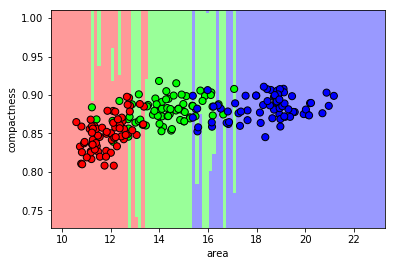

In [9]:
names = sorted(set(labels))
labels = np.array([names.index(ell) for ell in labels])

fig,ax = plot_decision(features, labels)
plt.show()

Образцы сорта Canadian представлены красными точками, сорта Коma - зелеными, а сорта Rosa - синими. Соответственные им области окрашены красным, зеленым и синим цветом. Возникает вопрос, почему области до странности вертикальны. Дело в том, что по оси х (площадь, area) отложен диапазона от 10 до 22, а по оси у (компактность, compactness) от 0,75 до 1,0. Это означает, что малое изменение х на графике оказывается гораздо значимее малого изменения у. Поэтому в расстояние между точками наибольший вклад вносит х.

Если вы изучали физику, то, наверное, обратили внимание, что мы суммируем длины, площади и безразмерные величины, не обращая внимания на единицы измерения (чего в реальной физической системе ни в коем случае нельзя делать). Необходимо привести все признаки к единой шкале. Решать эту проблему можно по-разному; проще всего воспользоваться __нормированными
z-оценками__. Z-оценка (Z-score) некоторого значения показывает, насколько далеко оно отстоит от среднего в единицах, равных стандартному отклонению. 

Вычисляется она следующим образом:
$$ f^\prime = \dfrac{f-\mu}{\sigma}$$

* $f$ - исходное значение признака, 
* $f^\prime$ - нормированное значение,
* $\mu$ - среднее значение признака, 
* $\sigma$ - стандартное отклонение.

Величины $\mu$ и $\sigma$ вычисляются по обучающим данным. Каковы бы ни были исходные данные, после нормировки __нулевое значение z-оценки__ соответствует среднему значению обучающих данных, __положительные значения__ - значениям больше среднего, а __отрицательные__ - значениям меньше среднего.

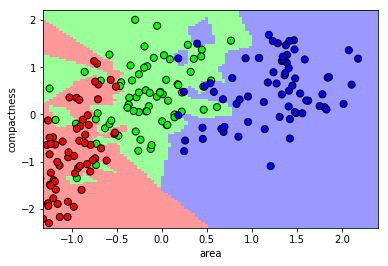

In [10]:
features -= features.mean(0)
features /= features.std(0)
fig,ax = plot_decision(features, labels)
plt.show()

Можно применить __конвейер операций (pipeline of transformations)__: первый eгo элемент выполняет преобразование, второй - классификацию.
Сначала импортируем классы конвейера и шкалирования
признаков:

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Теперь можно построить конвейер (combine):

In [12]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

Конструктор класса __Pipeline__ принимает список пар (str, clf). Каждой паре соответствует __один этап конвейера__: первый элемент - строка, именующая этап, второй - объект, выполняющий операцию. В более сложных приложениях по именам можно ссылаться на этапы конвейера.

In [13]:
means = []
for training,testing in kf:
    # Мы обучаем модель для fold с `fit` а затем применяем к
    # testing данным с `predict`:
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])

    # np.mean от массива booleans возвращает часть
    # правильных решений для этого fold:
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 92.4%


После нормировки все признаки измеряются в одних и тех же единицах (строго говоря, они теперь безразмерны, то есть говорить о единицах измерения бессмысленно), и над ними можно беспрепятственно производить математические операции. Если теперь прогнать классификатор по ближайшим соседям, то получится __accuracy 93%__ при той же самой пятипроходной перекрестной проверке!

In [14]:
def plot_decision(features, labels, num_neighbors=1):
    '''Plots decision boundary for KNN

    Parameters
    ----------
    features : ndarray
    labels : sequence

    Returns
    -------
    fig : Matplotlib Figure
    ax  : Matplotlib Axes
    '''
    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)

    model = KNeighborsClassifier(num_neighbors)
    model.fit(features[:, (0,2)], labels)
    C = model.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)

    colors = [(1., 0, 0), (0, 1., 0), (0, .0, 1.)]
    cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])

    fig,ax = plt.subplots()
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)

    for lab, ma, c in zip(range(3), "Do^", colors):
        ax.plot(features[labels == lab, 0], features[labels == lab, 2], ma, c=c, mec='black')

    return fig,ax

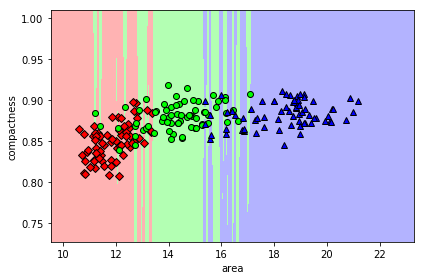

In [15]:
features, labels = load_dataset('seeds')
names = sorted(set(labels))
labels = np.array([names.index(ell) for ell in labels])

fig,ax = plot_decision(features, labels)
fig.tight_layout()

plt.show()

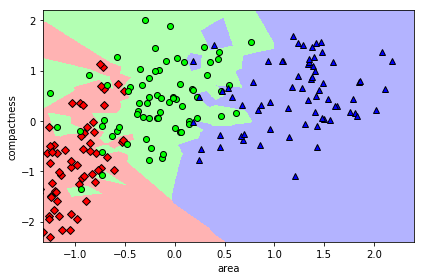

In [16]:
features -= features.mean(0)
features /= features.std(0)

fig,ax = plot_decision(features, labels)
fig.tight_layout()

plt.show()

Теперь границы выглядят совсем по-другому, и мы видим, что на результат влияют оба измерения. Полному набору данных соответствует семимерное пространство, изобразить которое затруднительно, но принцип тот же: если в исходных данных некоторые измерения доминируют, то после нормировки все становятся равноправны.

Изобразим также как будет выглядеть решающая граница, если вычислять ее по 11 ближайшим соседям

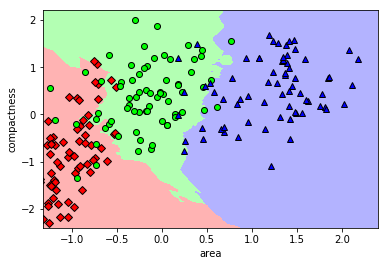

In [17]:
fig,ax = plot_decision(features, labels, 11)
plt.show()

## Бинарная и многоклассовая классификация

* __Бинарным классификатором__ на выходе дает один из двух классов, поскольку любое значение либо больше порога, либо меньше. 
* __Классификатор по ближайшим соседям__ - многоклассовый, его результатом может быть один из нескольких классов.

Часто бывает легче определить простой бинарный метод, чем метод, применяемый к многоклассовым задачам. Однако любую многоклассовую задачу можно свести к последовательности бинарных решений. Именно так мы поступили с набором данных Iris, хотя это получилось случайно: мы заметили, что один класс легко отделяется, и сосредоточили внимание на двух других, сведя задачу к двум бинарным решениям:
1. Это Iris Setosa (да или нет)?
2. Если нет, проверить, что это Iris Virginica (да или нет).

Разумеется, мы хотели бы поручить такого рода рассуждения компьютеру. Как обычно, есть несколько подходов к решению задачи о многоклассовой редукции.

Проще всего воспользоваться последовательностью классификаторов __один против остальных (one versus the rest)__. Для каждой возможной метки $l$ строим классификатор вида __это $l$ или что-то другое__? Если в ходе применения этого правила ровно один классификатор отвечает да, то решение получено. К сожалению, так бывает не всегда, и приходится решать, как быть, когда есть несколько положительных ответов или нет ни одного.

Можно вместо этого построить __дерево классификации (classification tree)__. Разобьем множество всех меток (labels) на два подмножества и построим классификатор, который спрашивает: "Куда отправить этот пример - налево или направо?". Такое разбиение можно продолжать рекурсивно, пока не останется одна метка. 

На рисунке изображено дерево рассуждений (tree of reasoning) для набора данных Iris. __Каждый ромб__ - это один бинарный классификатор. Понятно, что дерево могло бы быть больше и охватывать много решений. Таким образом, любой классификатор, который годится для бинарной классификации, можно легко обобщить на любое число классов.

<img src = "img/tree-of-reasoning-for-Iris-dataset.jpg" width='700'>

Есть много других способов превратить бинарный алгоритм в многоклассовый. Ни один нз них не является однозначно предпочтительным во всех случаях. В модуле scikit-learn реализовано несколько таких алгоритмов с подмодуле __sklearn.multiclass. __

## Резюме

* __Классификация (Classification)__ - обобщение примеров для построения модели (то есть набор правил, которые могут быть применены к новым, ранее не классифицированным объектам)

* __Погрешность на обучающих данных (training error)__ - вещь обманчивая, поскольку дает излишне оптимистическую оценку поведения модели. Модель следует оценивать на __тестовых данных (testing data)__, которые не использовались для обучения. Чтобы не расходовать слишком много примеров на тестирование, применяется __метод перекрестной проверки (cross-validation schedule)__, благодаря которому мы получаем лучшее из обоих миров (ценой увелнчения объема вычислений).

* __Признаки (Features)__ вовсе не являются предопределенными, их выбор и проектирование - неотьемлемая часть конструирования __конвейера машинного обучения (machine learning pipeline)__. На самом деле, именно в этой области часто можно добиться наибольшего увеличения accuracy, потому что качественные данные лучше изощренных алгоритмов.